# **DDoS detection notebook for preprocessing and model creation**

Import all required libraries and mount my Google drive

In [1]:
"""
Data preprocessing Jupiter notebook for the CICDDoS2019 dataset

Author: Thomas Roethenbaugh
Date: 02/04/2025
Version: 2.5
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Mounting my google drive to pull in the datasets
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Verify by listing the files in the drive
#!ls /content/drive/My\ Drive/ | grep .parquet

# List of Parquet files
files = [
    #"/content/drive/MyDrive/DNS-testing.parquet",   ## can be removed
    "/content/drive/MyDrive/LDAP-testing.parquet",
    "/content/drive/MyDrive/LDAP-training.parquet", "/content/drive/MyDrive/MSSQL-testing.parquet",
    "/content/drive/MyDrive/MSSQL-training.parquet", "/content/drive/MyDrive/NetBIOS-testing.parquet",
    "/content/drive/MyDrive/NetBIOS-training.parquet",
    #"/content/drive/MyDrive/NTP-testing.parquet",   ## can be removed
    #"/content/drive/MyDrive/Portmap-training.parquet",  ## can be removed
    #"/content/drive/MyDrive/SNMP-testing.parquet",  ## can be removed
    "/content/drive/MyDrive/Syn-testing.parquet", "/content/drive/MyDrive/Syn-training.parquet",
    #"/content/drive/MyDrive/TFTP-testing.parquet",  ## can be removed
    "/content/drive/MyDrive/UDPLag-testing.parquet",
    "/content/drive/MyDrive/UDPLag-training.parquet", "/content/drive/MyDrive/UDP-testing.parquet",
    "/content/drive/MyDrive/UDP-training.parquet"
]

# This formmatting looks a little weird, but that's because I've removed the
# files that only have testing or training data which is causing problems
# with the encoding

# Verify files were imported correctly
#df = pd.read_parquet(files[0])
#print(df.head())

Mounted at /content/drive/


# Data cleaning and analysis

## Merge all files and divide by testing vs training data



In [2]:
merged_training_data = []
merged_testing_data = []

for file in files:
    dataframe = pd.read_parquet(file)

    # Check the filename to determine if it's training or testing data
    if "training" in file.lower():
        merged_training_data.append(dataframe)
    elif "testing" in file.lower():
        merged_testing_data.append(dataframe)

# Combine all the dataframes
training_dataset = pd.concat(merged_training_data, ignore_index=True) # This is the merged dataset
testing_dataset = pd.concat(merged_testing_data, ignore_index=True)
print("Training dataset shape", training_dataset.shape)
print("Testing dataset shape:", testing_dataset.shape) # confirm that they have been merged correctly

Training dataset shape (120065, 78)
Testing dataset shape: (38973, 78)


## Merge column types for both training and testing datasets so that they are the same

In [3]:
# Create seprate set of columns to make comparison easier
training_columns = set(training_dataset.columns)
testing_columns = set(testing_dataset.columns)
print("Columns in Training Data:", training_columns)
print("Columns in Testing Data:", testing_columns)

# Which columns are the same?
common_columns = list(training_columns.intersection(testing_columns))
print("\nCommon Columns:", common_columns)

# Merged column datasets based on difference
training_data_mapped = training_dataset[common_columns]
testing_data_mapped = testing_dataset[common_columns]
print("\nTraining Data Columns after Mapping:", list(training_data_mapped.columns))
print("Testing Data Columns after Mapping:", list(testing_data_mapped.columns))

# Verify if successful
if list(training_data_mapped.columns) == list(testing_data_mapped.columns):
    print("\nColumn mapping successful!")
else:
    print("\nColumn mapping incomplete, columns are still not the same")

#print(training_data_mapped.info())
#print(testing_data_mapped.info())

Columns in Training Data: {'CWE Flag Count', 'Fwd Header Length', 'Idle Std', 'Init Bwd Win Bytes', 'ACK Flag Count', 'Bwd IAT Mean', 'Active Min', 'Fwd Seg Size Min', 'Bwd Packets Length Total', 'Bwd Packets/s', 'Label', 'Bwd PSH Flags', 'Bwd Packet Length Max', 'Avg Bwd Segment Size', 'Packet Length Mean', 'Bwd Packet Length Std', 'Fwd Packets/s', 'Bwd Header Length', 'Fwd Packet Length Std', 'Flow Bytes/s', 'URG Flag Count', 'Bwd IAT Max', 'Subflow Fwd Bytes', 'Bwd Avg Bulk Rate', 'Packet Length Min', 'Bwd Avg Bytes/Bulk', 'Fwd IAT Total', 'Fwd IAT Min', 'Active Max', 'Fwd Packets Length Total', 'Fwd IAT Max', 'Fwd Packet Length Mean', 'Bwd IAT Total', 'Flow IAT Mean', 'Subflow Fwd Packets', 'Init Fwd Win Bytes', 'Flow IAT Std', 'Bwd Avg Packets/Bulk', 'Fwd Packet Length Max', 'Subflow Bwd Packets', 'Fwd URG Flags', 'Fwd Avg Bulk Rate', 'Bwd Packet Length Min', 'Flow Duration', 'Idle Mean', 'Fwd Avg Bytes/Bulk', 'Idle Min', 'PSH Flag Count', 'Fwd Avg Packets/Bulk', 'FIN Flag Count',

## Merge column data types, this section covers differences between the data types of the columns. Namely, that some columns will have the same name but might be listed as float64 in training but float32 in another. This code will eliminate that difference and merge the two

In [4]:
print("Data types BEFORE correction:")
print("Training data types:\n", training_data_mapped.dtypes)
print("\nTesting data types:\n", testing_data_mapped.dtypes)

# Identify columns with different data Types
mismatched_dtypes_columns = {}
for column in training_data_mapped.columns:
    if training_data_mapped[column].dtype != testing_data_mapped[column].dtype:
        mismatched_dtypes_columns[column] = {
            'training_dtype': training_data_mapped[column].dtype,
            'testing_dtype': testing_data_mapped[column].dtype
        }
print("\nColumns with mismatched data types", mismatched_dtypes_columns)

# Resolve Data Type Mismatches by converting to common type
for column, dtypes in mismatched_dtypes_columns.items():
    training_dtype = dtypes['training_dtype']
    testing_dtype = dtypes['testing_dtype']

    print(f"\nResolving dtype mismatch for column: {column}")
    print(f"  Training data type: {training_dtype}, Testing data types: {testing_dtype}")

    # Convert lower data type like float32 to higher 64, I know this is ugly
    # btw but it's simple to me and I don't need to be efficent
    if training_dtype == 'int64' and testing_dtype == 'int32':
        target_dtype = 'int64'
    elif training_dtype == 'int32' and testing_dtype == 'int64':
        target_dtype = 'int64'
    elif training_dtype == 'float64' and testing_dtype == 'float32':
        target_dtype = 'float64'
    elif training_dtype == 'float32' and testing_dtype == 'float64':
        target_dtype = 'float64'
    else:
        # Default if it doesn't fit to convert to float64
        if pd.api.types.is_numeric_dtype(training_dtype) and pd.api.types.is_numeric_dtype(testing_dtype):
            target_dtype = 'float64'
        else:
            print(f"  WARNING! No specific casting rule defined for {training_dtype} vs {testing_dtype} manual review needed  for this column {column}")
            target_dtype = None # Indicate manual changes might be needed for this datatype

    if target_dtype:
        print(f"  Casting both training and testing columns '{column}' to type: {target_dtype}")
        training_data_mapped[column] = training_data_mapped[column].astype(target_dtype)
        testing_data_mapped[column] = testing_data_mapped[column].astype(target_dtype)
    else:
        print(f"  Skipping casting for column '{column}'  manual resolution required")

print("\nData types AFTER correction:")
print("Training data types: \n", training_data_mapped.dtypes)
print("\nTesting data types: \n", testing_data_mapped.dtypes)

# Verification of task
mismatchedDtypesAfterCast = False
for column in training_data_mapped.columns:
    if training_data_mapped[column].dtype != testing_data_mapped[column].dtype:
        print(f"ERROR!!: Column '{column}' STILL has inconsistent data types after casting: Training {training_data_mapped[column].dtype}, Testing {testing_data_mapped[column].dtype}")
        mismatchedDtypesAfterCast = True

if not mismatchedDtypesAfterCast:
    print("\nData type correction successful!")
else:
    print("\nData type correction may be incomplete")

# Now, training_data_mapped and testing_data_mapped should have consistent column sets AND consistent column data types.

#print(training_data_mapped.info())
#print(testing_data_mapped.info())

Data types BEFORE correction:
Training data types:
 CWE Flag Count             int8
Fwd Header Length         int64
Idle Std                float32
Init Bwd Win Bytes        int32
ACK Flag Count             int8
                         ...   
Fwd Act Data Packets      int16
ECE Flag Count             int8
SYN Flag Count             int8
RST Flag Count             int8
Packet Length Max       float32
Length: 78, dtype: object

Testing data types:
 CWE Flag Count             int8
Fwd Header Length         int64
Idle Std                float32
Init Bwd Win Bytes        int32
ACK Flag Count             int8
                         ...   
Fwd Act Data Packets       int8
ECE Flag Count             int8
SYN Flag Count             int8
RST Flag Count             int8
Packet Length Max       float32
Length: 78, dtype: object

Columns with mismatched data types {'Bwd Header Length': {'training_dtype': dtype('int64'), 'testing_dtype': dtype('int32')}, 'Subflow Fwd Packets': {'training_dtype': d

## Remove single unique column values to avoid one weird column skewing the ML model

In [5]:
single_unique_cols = [col for col in training_data_mapped.columns if training_data_mapped[col].nunique() == 1]
# Drop these columns from both the training and testing DataFrames.
training_data_mapped.drop(columns=single_unique_cols, inplace=True)
testing_data_mapped.drop(columns=single_unique_cols, inplace=True)

print(f"Dropped {len(single_unique_cols)} columns with single unique values")

Dropped 12 columns with single unique values


## Remove highly correlated columns to improve the perfromence of the ML model (TODO test both with and without this step to ensure it is nesscary)

In [6]:
# Calculate the Correlation Matrix for the Training Dataset
correlation_matrix = training_data_mapped.corr(numeric_only=True) # Use numeric_only=True to avoid warning

# Threshold set to 0.8 arbitarily, TODO test performence
highly_correlated_pairs = set() # Used a set to avoid duplicates
threshold = 0.8

# Iterate through the upper triangle of the correlation matrix (to avoid redundancy)
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        col_i = correlation_matrix.columns[i]
        col_j = correlation_matrix.columns[j]
        if abs(correlation_matrix.iloc[i, j]) >= threshold:
            highly_correlated_pairs.add(tuple(sorted((col_i, col_j)))) # Add pair as tuple to set

print("Highly Correlated Column Pairs (correlation >= {}):".format(threshold))
for pair in highly_correlated_pairs:
    col1, col2 = pair
    correlation_value = correlation_matrix.loc[col1, col2]
    print(f"Column 1: {col1}, Column 2: {col2}, Correlation: {correlation_value:.4f}")

# Create set and list of columns that need to be dropped
columns_to_drop = set()
dropped_columns_list = []

# Iterate through the pairs and choose which column to drop.
# drop the second column encountered in the iteration.
all_ready_dropped = set() # Keep track of already dropped to avoid dropping twice

for pair in highly_correlated_pairs:
    col1, col2 = pair
    if col1 not in all_ready_dropped and col2 not in all_ready_dropped: # Check if not already marked for drop
        # choose to drop the second column
        column_to_drop = col2
        columns_to_drop.add(column_to_drop)
        dropped_columns_list.append(column_to_drop)
        all_ready_dropped.add(column_to_drop)


print("\nColumns to be dropped (based on correlation >= {}):".format(threshold), dropped_columns_list)

# Drop Highly Correlated Columns from Both Training and Testing Datasets
# THIS IS NOW THE NEW DATA FORMAT, DON'T FORGET AND PLEASE UPDATE!!!!!!!!!!!
training_data_reduced = training_data_mapped.drop(columns=columns_to_drop, errors='ignore') # errors='ignore' if some columns were already dropped or not present
testing_data_reduced = testing_data_mapped.drop(columns=columns_to_drop, errors='ignore')

print("\nShape before dropping highly correlated columns:")
print("Training data shape:", training_data_mapped.shape)
print("Testing data shape:", testing_data_mapped.shape)
print("\nShape after dropping highly correlated columns:")
print("Training data shape:", training_data_reduced.shape)
print("Testing data shape:", testing_data_reduced.shape)

print("\nColumns in training data AFTER dropping highly correlated columns:\n", list(training_data_reduced.columns))
print("\nColumns in testing data AFTER dropping highly correlated columns:\n", list(testing_data_reduced.columns))

Highly Correlated Column Pairs (correlation >= 0.8):
Column 1: Avg Bwd Segment Size, Column 2: Bwd Packet Length Std, Correlation: 0.8610
Column 1: Fwd Packet Length Min, Column 2: Packet Length Mean, Correlation: 0.9205
Column 1: Flow IAT Std, Column 2: Fwd IAT Max, Correlation: 0.8952
Column 1: Avg Packet Size, Column 2: Fwd Packet Length Mean, Correlation: 0.9664
Column 1: Flow IAT Std, Column 2: Fwd IAT Mean, Correlation: 0.9540
Column 1: Flow Duration, Column 2: Fwd IAT Std, Correlation: 0.8129
Column 1: Subflow Bwd Bytes, Column 2: Total Backward Packets, Correlation: 0.9757
Column 1: Bwd Packet Length Mean, Column 2: Bwd Packet Length Std, Correlation: 0.8610
Column 1: Flow IAT Max, Column 2: Idle Mean, Correlation: 0.9685
Column 1: Flow IAT Max, Column 2: Flow IAT Std, Correlation: 0.8971
Column 1: Bwd IAT Max, Column 2: Bwd IAT Mean, Correlation: 0.8480
Column 1: Bwd IAT Max, Column 2: Bwd IAT Total, Correlation: 0.8506
Column 1: Avg Bwd Segment Size, Column 2: Bwd Packet Leng

## Null data removal / checking

In [7]:
print(training_data_reduced.isnull().sum().sum(), "No training null values")
print(testing_data_reduced.isnull().sum().sum(), "No testing null values")

0 No training null values
0 No testing null values


## Remove all duplicate data rows to avoid overfitting of model

In [8]:
# Show shape before and after removing duplicates
print(training_data_reduced.shape, "Training shape before")
print(training_data_reduced.duplicated().sum(), "duplicate rows to remove")
training_data_reduced.drop_duplicates(inplace=True)
training_data_reduced.reset_index(inplace=True, drop=True)
print(training_data_reduced.shape, "Training shape after")

# Show shape before and after removing duplicates
print(testing_data_reduced.shape, "Testing shape before ")
print(testing_data_reduced.duplicated().sum(), "duplicate rows to remove")
testing_data_reduced.drop_duplicates(inplace=True)
testing_data_reduced.reset_index(inplace=True, drop=True) # fix intexing
print(testing_data_reduced.shape,"Testing shape after")

(120065, 32) Training shape before
6655 duplicate rows to remove
(113410, 32) Training shape after
(38973, 32) Testing shape before 
762 duplicate rows to remove
(38211, 32) Testing shape after


## Check for infinate values (TODO this step might not be nessisary)

In [9]:
np.isinf(training_data_reduced[['Flow Bytes/s', 'Flow Packets/s']]).sum()
np.isinf(testing_data_reduced[['Flow Bytes/s', 'Flow Packets/s']]).sum()

training_data_reduced.describe()
testing_data_reduced.describe()

,CWE Flag Count,Fwd Header Length,Idle Std,Init Bwd Win Bytes,ACK Flag Count,Bwd Packets Length Total,Bwd Packets/s,Avg Bwd Segment Size,Bwd Header Length,Fwd Packet Length Std,...,Avg Fwd Segment Size,Flow Packets/s,Bwd IAT Min,Fwd PSH Flags,Flow IAT Min,Protocol,Down/Up Ratio,Fwd Act Data Packets,SYN Flag Count,Packet Length Max
count,38211.000000,3.821100e+04,3.821100e+04,38211.000000,38211.000000,3.821100e+04,3.821100e+04,38211.000000,3.821100e+04,38211.000000,...,38211.000000,3.821100e+04,38211.000000,38211.000000,3.821100e+04,38211.000000,38211.000000,38211.000000,38211.000000,38211.000000
mean,0.051006,-9.226981e+07,4.738347e+05,937.837691,0.232839,7.156456e+02,1.343765e+03,28.799990,-3.865807e+06,20.576248,...,287.050110,3.297778e+05,1.102091,0.032190,5.341144e+03,13.117322,0.297480,2.307163,0.000733,379.073700
std,0.220013,5.837730e+08,1.827608e+06,5711.567009,0.422646,1.304963e+04,2.290483e+04,126.272560,9.040096e+07,68.849663,...,337.574158,6.946558e+05,6.044177,0.176506,1.698002e+05,5.322755,0.677723,4.228342,0.027060,519.534729
min,0.000000,-2.125438e+10,0.000000e+00,-1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,-2.125438e+09,0.000000,...,0.000000,5.105157e-02,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.800000e+01,0.000000e+00,-1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,2.747813e+01,0.000000,0.000000,1.000000e+00,6.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,6.400000e+01,0.000000e+00,-1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,...,348.000000,3.817195e+01,0.000000,0.000000,1.000000e+00,17.000000,0.000000,1.000000,0.000000,369.000000
75%,0.000000,1.200000e+02,0.000000e+00,-1.000000,0.000000,0.000000e+00,2.986580e-01,0.000000,4.000000e+01,24.856924,...,362.100006,4.081633e+04,1.000000,0.000000,1.000000e+00,17.000000,0.000000,3.000000,0.000000,406.000000
max,1.000000,1.219200e+04,4.209234e+07,65535.000000,1.000000,1.468048e+06,2.000000e+06,2085.714355,1.636400e+04,1271.117188,...,2595.555664,3.000000e+06,249.000000,1.000000,1.234823e+07,17.000000,12.000000,96.000000,1.000000,3548.000000


## The testing data files weirdly have inconsistaint labels like DrDDoS_UDP instead of just UDP like the training set so that needs to be fixed

In [10]:
print("BEFORE \n")
print(testing_data_reduced.Label.value_counts())
print(training_data_reduced.Label.value_counts())

# Goes through all the stupid labels for TESTING DATASET
for index, row in testing_data_reduced.iterrows():
    if row['Label'] == 'DrDoS_UDP':
        testing_data_reduced.at[index, 'Label'] = 'UDP'
    if row['Label'] == 'DrDoS_MSSQL':
        testing_data_reduced.at[index, 'Label'] = 'MSSQL'
    if row['Label'] == 'DrDoS_LDAP':
        testing_data_reduced.at[index, 'Label'] = 'LDAP'
    if row['Label'] == 'DrDoS_NetBIOS':
        testing_data_reduced.at[index, 'Label'] = 'NetBIOS'
    """
    Original problems between the training and testing dataset labels being mis
    -aligned
    """
    if row['Label'] == 'UDPLag':
        testing_data_reduced.at[index, 'Label'] = 'UDP-lag'
        ### THIS IS FOR IF I USE ALL THE DATA FILES
    if row['Label'] == 'DrDoS_NTP':
        testing_data_reduced.at[index, 'Label'] = 'NTP'
    if row['Label'] == 'DrDoS_DNS':
        testing_data_reduced.at[index, 'Label'] = 'DNS'
    if row['Label'] == 'DrDoS_SNMP':
        testing_data_reduced.at[index, 'Label'] = 'SNMP'
        ### END

# Labels for TRANING DATASET
for index, row in training_data_reduced.iterrows():
    if row['Label'] == 'UDPLag':
        training_data_reduced.at[index, 'Label'] = 'UDP-lag'


print("AFTER \n")
print(testing_data_reduced.Label.value_counts())
print(training_data_reduced.Label.value_counts())

BEFORE 

Label
Benign           10588
DrDoS_UDP        10166
UDP-lag           8657
DrDoS_MSSQL       6212
DrDoS_LDAP        1438
DrDoS_NetBIOS      598
Syn                501
WebDDoS             51
Name: count, dtype: int64
Label
Syn        44474
Benign     40943
UDP        17152
MSSQL       8429
LDAP        1882
NetBIOS      475
UDPLag        55
Name: count, dtype: int64
AFTER 

Label
Benign     10588
UDP        10166
UDP-lag     8657
MSSQL       6212
LDAP        1438
NetBIOS      598
Syn          501
WebDDoS       51
Name: count, dtype: int64
Label
Syn        44474
Benign     40943
UDP        17152
MSSQL       8429
LDAP        1882
NetBIOS      475
UDP-lag       55
Name: count, dtype: int64


## Remove WebDDoS as it has very few values (might remove if I combine all paraquet files)

In [11]:
for index, row in testing_data_reduced.iterrows():
    if row['Label'] == 'WebDDoS':
      testing_data_reduced.drop(index,  inplace=True)

print(testing_data_reduced.Label.value_counts())

print(training_data_reduced.Label.value_counts())

Label
Benign     10588
UDP        10166
UDP-lag     8657
MSSQL       6212
LDAP        1438
NetBIOS      598
Syn          501
Name: count, dtype: int64
Label
Syn        44474
Benign     40943
UDP        17152
MSSQL       8429
LDAP        1882
NetBIOS      475
UDP-lag       55
Name: count, dtype: int64


## Export the two datasets for analysis

In [12]:
training_data_reduced.to_csv('trainingdata.csv')
testing_data_reduced.to_csv('testingdata.csv')

# Data analysis

General data information

In [13]:
print(training_data_reduced.info())
print(training_data_reduced["Label"].value_counts())
print(testing_data_reduced.info())
print(testing_data_reduced["Label"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113410 entries, 0 to 113409
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   CWE Flag Count            113410 non-null  int8   
 1   Fwd Header Length         113410 non-null  int64  
 2   Idle Std                  113410 non-null  float32
 3   Init Bwd Win Bytes        113410 non-null  int32  
 4   ACK Flag Count            113410 non-null  int8   
 5   Bwd Packets Length Total  113410 non-null  float32
 6   Bwd Packets/s             113410 non-null  float32
 7   Label                     113410 non-null  object 
 8   Avg Bwd Segment Size      113410 non-null  float32
 9   Bwd Header Length         113410 non-null  int64  
 10  Fwd Packet Length Std     113410 non-null  float32
 11  Flow Bytes/s              113410 non-null  float64
 12  URG Flag Count            113410 non-null  int8   
 13  Bwd IAT Max               113410 non-null  f

Visual graphs

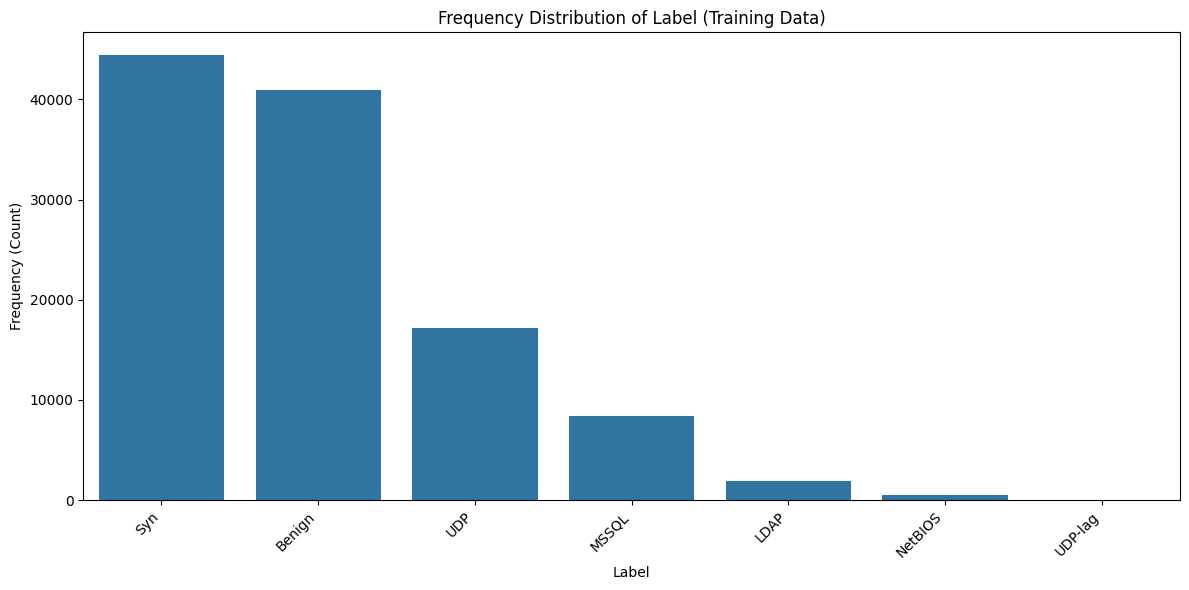

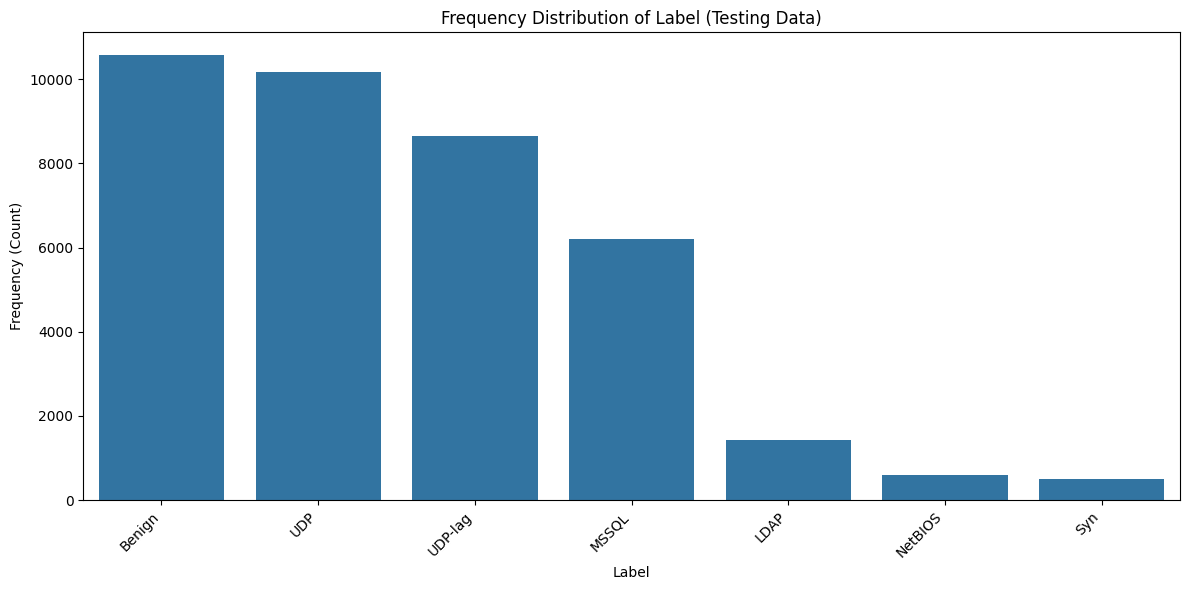

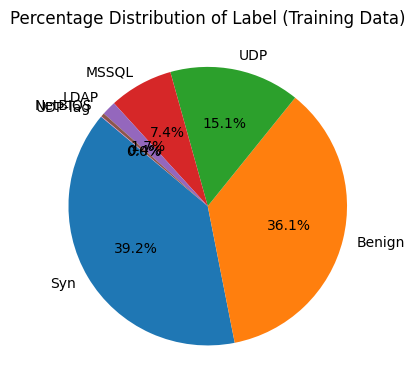

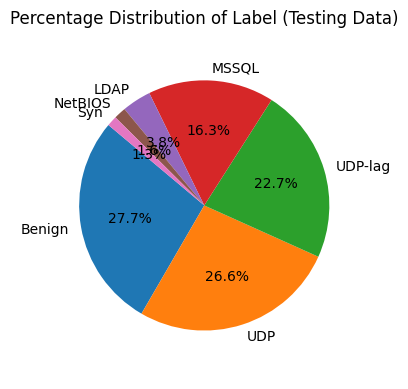

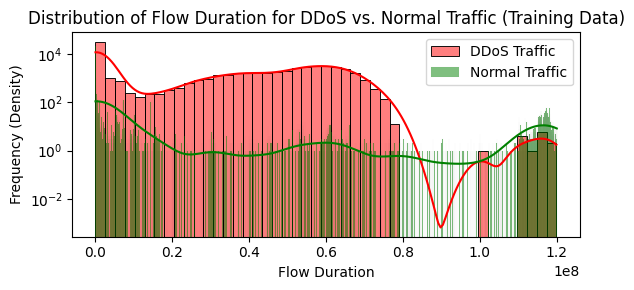

<ipython-input-14-e8891ac50163>:81: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


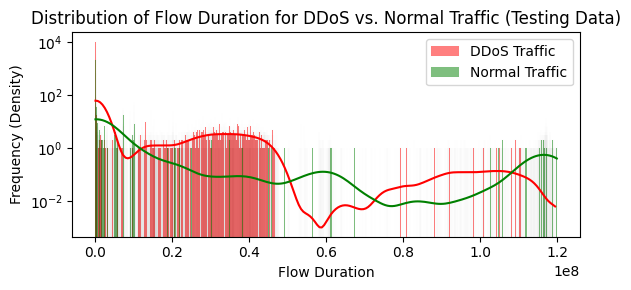

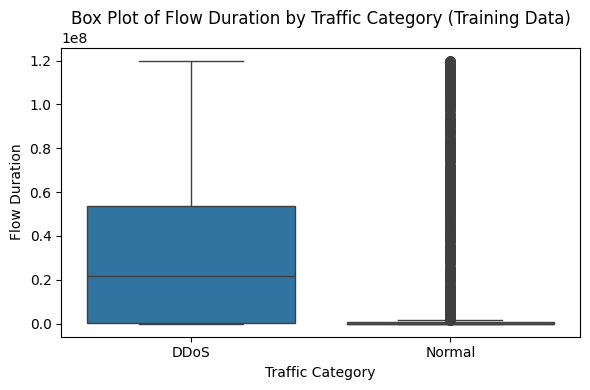

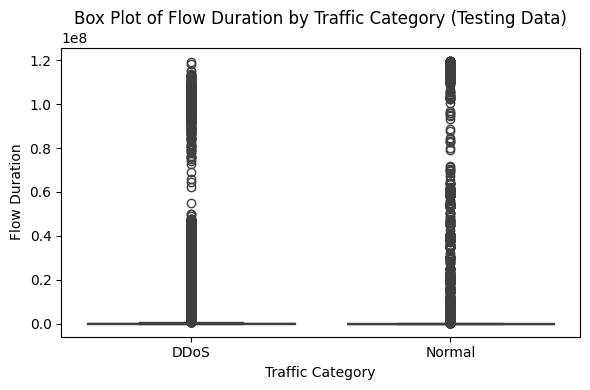

In [14]:
categorical_column = 'Label' # Specify the categorical column to visualize

# Frequency Distribution (Bar Plot)
plt.figure(figsize=(12,6)) # size of visual representaion
sns.countplot(data=training_data_reduced, x=categorical_column, order = training_data_reduced[categorical_column].value_counts().index) # Order by frequency
plt.title(f'Frequency Distribution of {categorical_column} (Training Data)')
plt.xlabel(categorical_column)
plt.ylabel('Frequency (Count)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
# Frequency Distribution (Bar Plot) TESTING DATA
plt.figure(figsize=(12, 6)) # size of visual representaion
sns.countplot(data=testing_data_reduced, x=categorical_column, order = testing_data_reduced[categorical_column].value_counts().index) # Order by frequency
plt.title(f'Frequency Distribution of {categorical_column} (Testing Data)')
plt.xlabel(categorical_column)
plt.ylabel('Frequency (Count)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Percentage Distribution (Pie Chart)
label_counts = training_data_reduced[categorical_column].value_counts()
plt.figure(figsize=(4, 4))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Percentage Distribution of {categorical_column} (Training Data)')
plt.axis('equal')
plt.tight_layout()
plt.show()
# Percentage Distribution (Pie Chart) TESTING DATA
label_counts = testing_data_reduced[categorical_column].value_counts()
plt.figure(figsize=(4, 4))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Percentage Distribution of {categorical_column} (Testing Data)')
plt.axis('equal')
plt.tight_layout()
plt.show()

# Flow Duration Distribution for DDoS and Normal Traffic
flow_duration_column = 'Flow Duration'
# This is the list of labels that will be used for the visulisation
ddos_labels = ['Syn', 'UDP', 'MSSQL', 'LDAP', 'NetBIOS', 'UDP-lag']
normal_labels = ['Benign']
# Create categories based on labels (adjust based on your actual labels)
training_data_reduced['Traffic_Category'] = training_data_reduced['Label'].apply(lambda label: 'DDoS' if label in ddos_labels else 'Normal' if label in normal_labels else 'Other')
# Filter data for DDoS and Normal traffic
ddos_traffic = training_data_reduced[training_data_reduced['Traffic_Category'] == 'DDoS']
normal_traffic = training_data_reduced[training_data_reduced['Traffic_Category'] == 'Normal']
# Histogram Distribution of the flow duration
plt.figure(figsize=(6, 3))
sns.histplot(ddos_traffic[flow_duration_column], color="red", label='DDoS Traffic', kde=True)
sns.histplot(normal_traffic[flow_duration_column], color="green", label='Normal Traffic', kde=True)
plt.title(f'Distribution of {flow_duration_column} for DDoS vs. Normal Traffic (Training Data)')
plt.xlabel(flow_duration_column)
plt.ylabel('Frequency (Density)')
plt.legend()
plt.yscale('log') # test for skewed results
plt.tight_layout()
plt.show()

# Flow Duration Distribution for DDoS and Normal Traffic TESTING DATA
flow_duration_column = 'Flow Duration'
# This is the list of labels that will be used for the visulisation
ddos_labels = ['Syn', 'UDP', 'MSSQL', 'LDAP', 'NetBIOS', 'UDP-lag', 'NTP ']   ### Add to categories
normal_labels = ['Benign']

# Create categories based on labels
testing_data_reduced['Traffic_Category'] = testing_data_reduced['Label'].apply(lambda label: 'DDoS' if label in ddos_labels else 'Normal' if label in normal_labels else 'Other')
# Filter data for DDoS and Normal traffic
ddos_traffic = testing_data_reduced[testing_data_reduced['Traffic_Category'] == 'DDoS']
normal_traffic = testing_data_reduced[testing_data_reduced['Traffic_Category'] == 'Normal']
# Histogram Distribution of the flow duration
plt.figure(figsize=(6, 3))
sns.histplot(ddos_traffic[flow_duration_column], color="red", label='DDoS Traffic', kde=True)
sns.histplot(normal_traffic[flow_duration_column], color="green", label='Normal Traffic', kde=True)
plt.title(f'Distribution of {flow_duration_column} for DDoS vs. Normal Traffic (Testing Data)')
plt.xlabel(flow_duration_column)
plt.ylabel('Frequency (Density)')
plt.legend()
plt.yscale('log') # test for skewed results
plt.tight_layout()
plt.show()

# Box Plot for flow durationcomparison
plt.figure(figsize=(6, 4))
sns.boxplot(data=training_data_reduced, x='Traffic_Category', y=flow_duration_column)
plt.title(f'Box Plot of {flow_duration_column} by Traffic Category (Training Data)')
plt.xlabel('Traffic Category')
plt.ylabel(flow_duration_column)
plt.tight_layout()
plt.show()

# Box Plot for Flow Duration Comparison TESTING DATA
plt.figure(figsize=(6, 4))
sns.boxplot(data=testing_data_reduced, x='Traffic_Category', y=flow_duration_column)
plt.title(f'Box Plot of {flow_duration_column} by Traffic Category (Testing Data)')
plt.xlabel('Traffic Category')
plt.ylabel(flow_duration_column)
plt.tight_layout()
plt.show()

Further visualisations

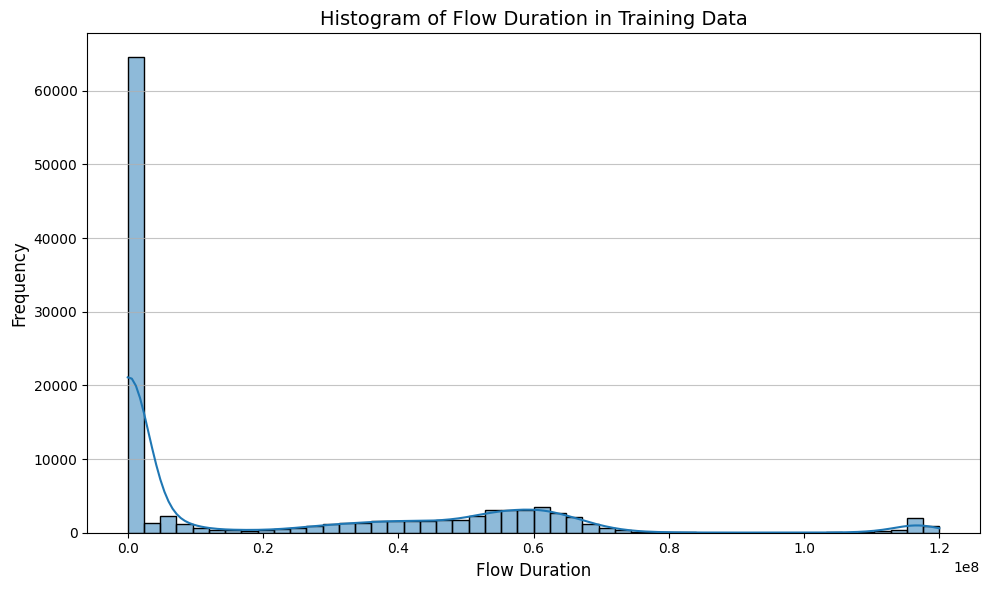

Insights from Histogram of 'Flow Duration':
Columns in training_data_reduced BEFORE boxplot: Index(['CWE Flag Count', 'Fwd Header Length', 'Idle Std', 'Init Bwd Win Bytes',
       'ACK Flag Count', 'Bwd Packets Length Total', 'Bwd Packets/s', 'Label',
       'Avg Bwd Segment Size', 'Bwd Header Length', 'Fwd Packet Length Std',
       'Flow Bytes/s', 'URG Flag Count', 'Bwd IAT Max', 'Active Max',
       'Fwd Packets Length Total', 'Flow IAT Mean', 'Subflow Fwd Packets',
       'Init Fwd Win Bytes', 'Fwd Packet Length Max', 'Bwd Packet Length Min',
       'Flow Duration', 'Avg Fwd Segment Size', 'Flow Packets/s',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Flow IAT Min', 'Protocol',
       'Down/Up Ratio', 'Fwd Act Data Packets', 'SYN Flag Count',
       'Packet Length Max', 'Traffic_Category'],
      dtype='object')


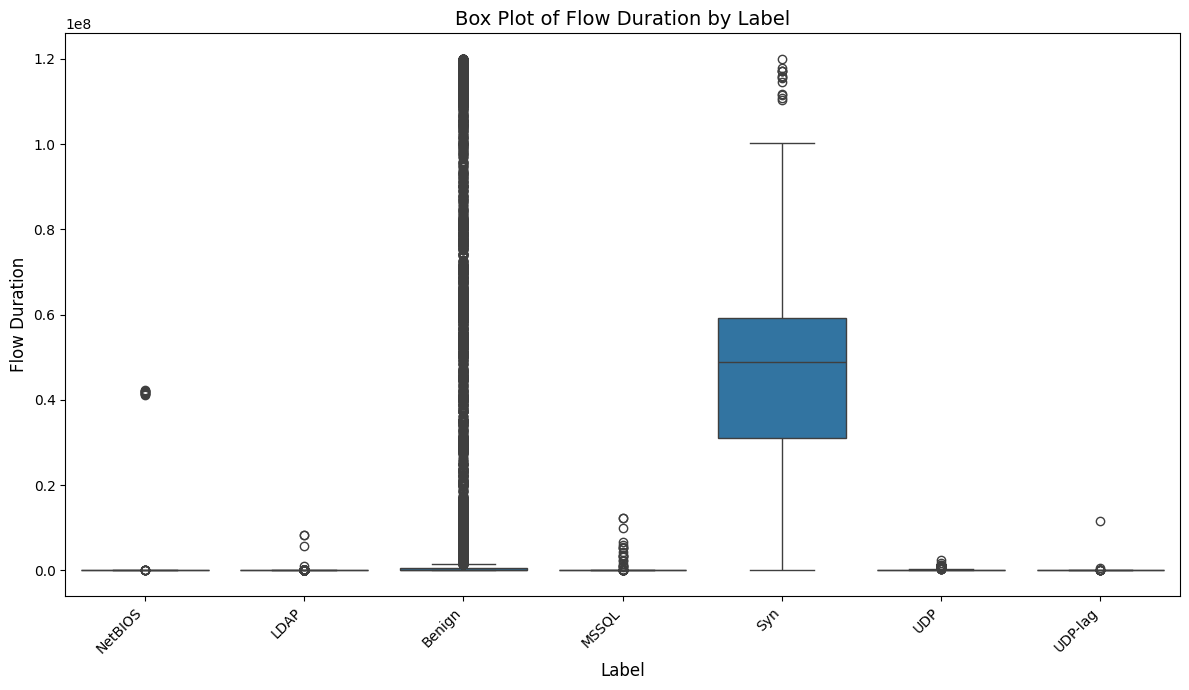

<ipython-input-15-6ed2e2f48f62>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index,


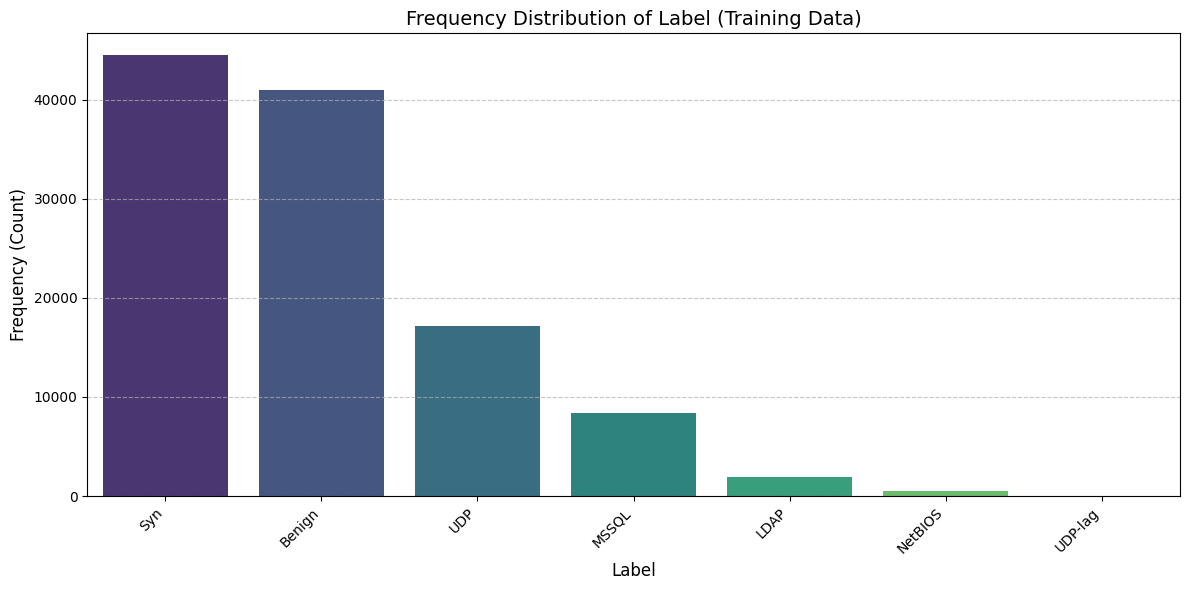

Insights from Bar Chart of 'Label':
- Visualizes the frequency of each attack category (Label) in the training data.
-------------------------------------------------



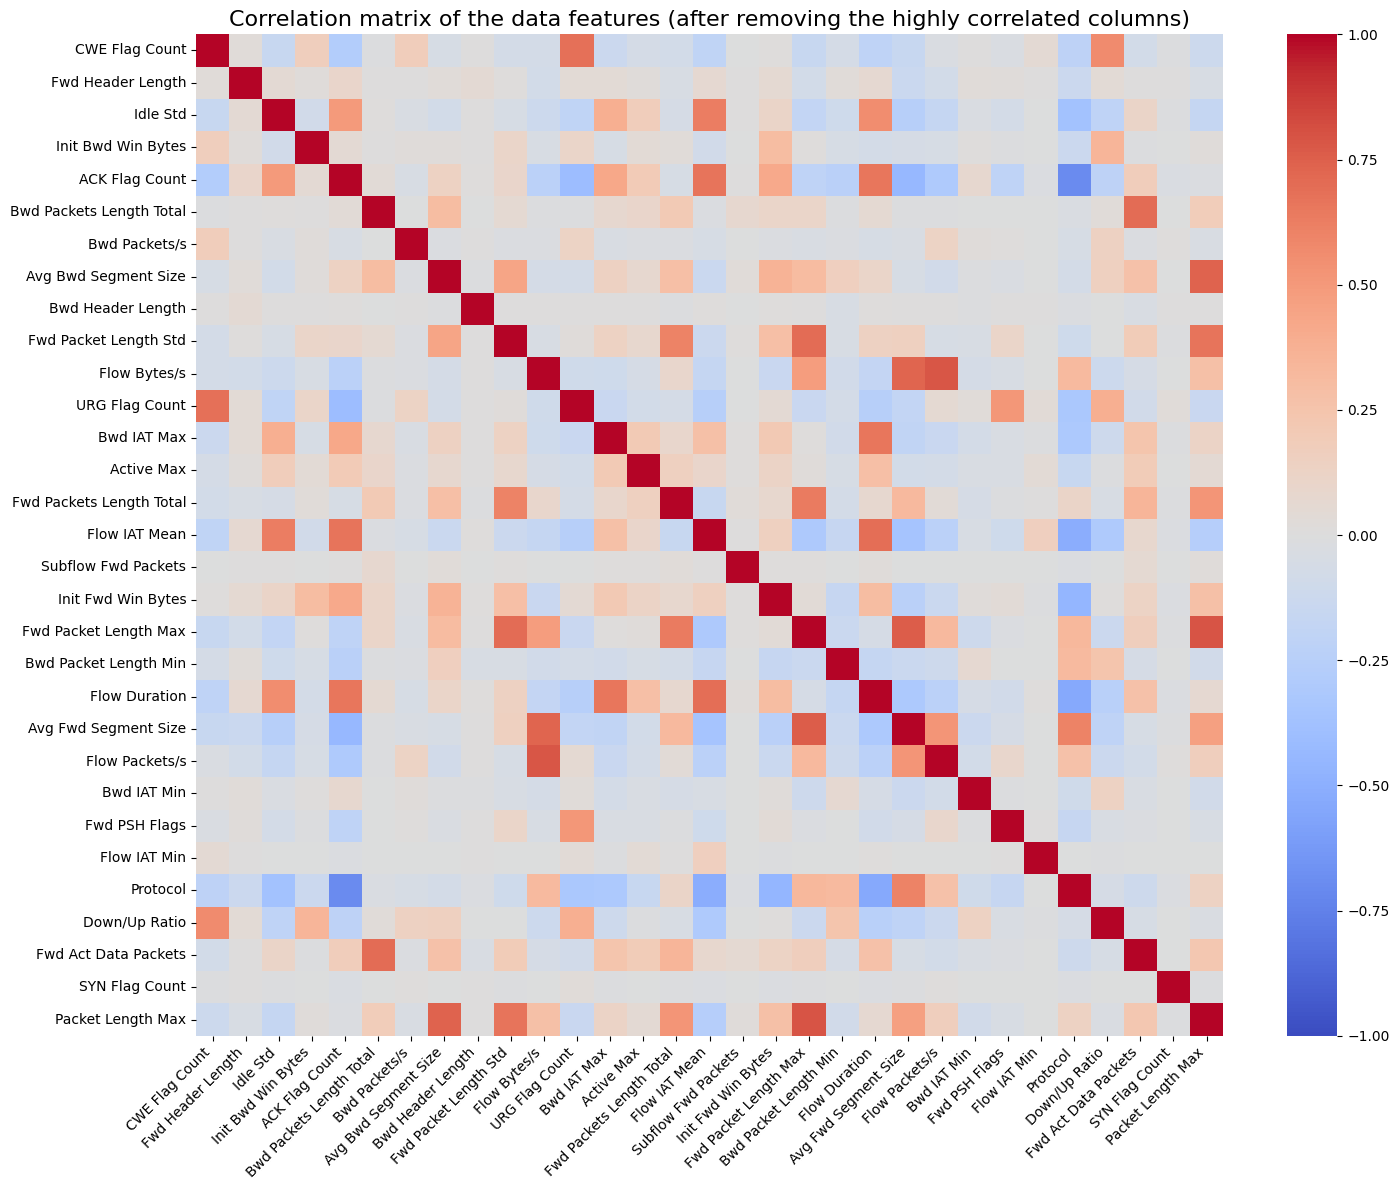

In [15]:
# Histogram of flow duration, demonstrates time taken for each flow
feature_to_visualize_hist = 'Flow Duration'
plt.figure(figsize=(10, 6))
sns.histplot(training_data_reduced[feature_to_visualize_hist], bins=50, kde=True)
plt.title(f'Histogram of {feature_to_visualize_hist} in Training Data', fontsize=14)
plt.xlabel(feature_to_visualize_hist, fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

print(f"Insights from Histogram of '{feature_to_visualize_hist}':")



# Flow Duration' Distribution by 'Label'
numerical_feature_boxplot = 'Flow Duration'  # Changed to 'Flow Duration'
categorical_feature_boxplot = 'Label'

print("Columns in training_data_reduced BEFORE boxplot:", training_data_reduced.columns) # Verification print

plt.figure(figsize=(12, 7))
sns.boxplot(x=categorical_feature_boxplot,
            y=numerical_feature_boxplot,
            data=training_data_reduced)

plt.title(f'Box Plot of {numerical_feature_boxplot} by {categorical_feature_boxplot}', fontsize=14)
plt.xlabel(categorical_feature_boxplot, fontsize=12)
plt.ylabel(numerical_feature_boxplot, fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Frequency of Label class imbalance check
categorical_feature_barchart = 'Label'
plt.figure(figsize=(12, 6))
label_counts = training_data_reduced[categorical_feature_barchart].value_counts()
sns.barplot(x=label_counts.index,
            y=label_counts.values,
            palette="viridis") # Use a visually appealing palette

plt.title(f'Frequency Distribution of {categorical_feature_barchart} (Training Data)', fontsize=14)
plt.xlabel(categorical_feature_barchart, fontsize=12)
plt.ylabel('Frequency (Count)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"Insights from Bar Chart of '{categorical_feature_barchart}':")
print("- Visualizes the frequency of each attack category (Label) in the training data.")
print("-------------------------------------------------\n")

# Correlation matrix
correlation_matrix_visual = training_data_reduced.corr(numeric_only=True)
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix_visual,cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation matrix of the data features (after removing the highly correlated columns)', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()

#print("Insights from correlation heatmap:")
#print("----------------------------------------------------\n")

Show pie graph and percentages of bengign vs ddos for all data

(151570, 33)




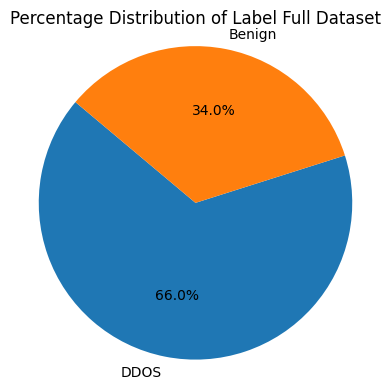

In [16]:
# merge testing training data
merged_full_dataset = pd.concat([training_data_reduced, testing_data_reduced], ignore_index=True)
print(merged_full_dataset.shape)

print("\n")


#### CONVERT LABELS TO DDOS AND BENIGN ONLY ####
for index, row in merged_full_dataset.iterrows():
    if row['Label'] == 'NTP':
        merged_full_dataset.at[index, 'Label'] = 'DDOS'
    if row['Label'] == 'TFTP':
        merged_full_dataset.at[index, 'Label'] = 'DDOS'
    if row['Label'] == 'Syn':
        merged_full_dataset.at[index, 'Label'] = 'DDOS'
    if row['Label'] == 'UDP':
        merged_full_dataset.at[index, 'Label'] = 'DDOS'
    if row['Label'] == 'MSSQL':
        merged_full_dataset.at[index, 'Label'] = 'DDOS'
    if row['Label'] == 'UDP-lag':
        merged_full_dataset.at[index, 'Label'] = 'DDOS'
    if row['Label'] == 'DNS':
        merged_full_dataset.at[index, 'Label'] = 'DDOS'
    if row['Label'] == 'LDAP':
        merged_full_dataset.at[index, 'Label'] = 'DDOS'
    if row['Label'] == 'SNMP':
        merged_full_dataset.at[index, 'Label'] = 'DDOS'
    if row['Label'] == 'NetBIOS':
        merged_full_dataset.at[index, 'Label'] = 'DDOS'
    if row['Label'] == 'Portmap':
        merged_full_dataset.at[index, 'Label'] = 'DDOS'


merged_full_dataset = merged_full_dataset.drop('Traffic_Category', axis=1)

# Percentage Distribution (Pie Chart)
label_counts = merged_full_dataset[categorical_column].value_counts()
plt.figure(figsize=(4, 4))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Percentage Distribution of {categorical_column} Full Dataset')
plt.axis('equal')
plt.tight_layout()
plt.show()


# ML model training & Testing

## Merge training and testing data

In [17]:
# merge training_data_reduced into testing_data_reduced
print(training_data_reduced.shape)
testing_data_reduced = pd.concat([testing_data_reduced, training_data_reduced], ignore_index=True)
print(testing_data_reduced.shape)

(113410, 33)
(151570, 33)


In [18]:
#testing_data_reduced.describe()
testing_data_reduced.head()

# IMPORTANT! this section could be overfitting the model will remove
# to avoid this but left here so that I remind myself to write about it
# in the report

"""
#### CONVERT LABELS TO DDOS AND BENIGN ONLY ####
for index, row in testing_data_reduced.iterrows():
    if row['Label'] == 'NTP':
        testing_data_reduced.at[index, 'Label'] = 'DDOS'
    if row['Label'] == 'TFTP':
        testing_data_reduced.at[index, 'Label'] = 'DDOS'
    if row['Label'] == 'Syn':
        testing_data_reduced.at[index, 'Label'] = 'DDOS'
    if row['Label'] == 'UDP':
        testing_data_reduced.at[index, 'Label'] = 'DDOS'
    if row['Label'] == 'MSSQL':
        testing_data_reduced.at[index, 'Label'] = 'DDOS'
    if row['Label'] == 'UDP-lag':
        testing_data_reduced.at[index, 'Label'] = 'DDOS'
    if row['Label'] == 'DNS':
        testing_data_reduced.at[index, 'Label'] = 'DDOS'
    if row['Label'] == 'LDAP':
        testing_data_reduced.at[index, 'Label'] = 'DDOS'
    if row['Label'] == 'SNMP':
        testing_data_reduced.at[index, 'Label'] = 'DDOS'
    if row['Label'] == 'NetBIOS':
        testing_data_reduced.at[index, 'Label'] = 'DDOS'
    if row['Label'] == 'Portmap':
        testing_data_reduced.at[index, 'Label'] = 'DDOS'


testing_data_reduced = testing_data_reduced.drop('Traffic_Category', axis=1)

"""

"\n#### CONVERT LABELS TO DDOS AND BENIGN ONLY ####\nfor index, row in testing_data_reduced.iterrows():\n    if row['Label'] == 'NTP':\n        testing_data_reduced.at[index, 'Label'] = 'DDOS'\n    if row['Label'] == 'TFTP':\n        testing_data_reduced.at[index, 'Label'] = 'DDOS'\n    if row['Label'] == 'Syn':\n        testing_data_reduced.at[index, 'Label'] = 'DDOS'\n    if row['Label'] == 'UDP':\n        testing_data_reduced.at[index, 'Label'] = 'DDOS'\n    if row['Label'] == 'MSSQL':\n        testing_data_reduced.at[index, 'Label'] = 'DDOS'\n    if row['Label'] == 'UDP-lag':\n        testing_data_reduced.at[index, 'Label'] = 'DDOS'\n    if row['Label'] == 'DNS':\n        testing_data_reduced.at[index, 'Label'] = 'DDOS'\n    if row['Label'] == 'LDAP':\n        testing_data_reduced.at[index, 'Label'] = 'DDOS'\n    if row['Label'] == 'SNMP':\n        testing_data_reduced.at[index, 'Label'] = 'DDOS'\n    if row['Label'] == 'NetBIOS':\n        testing_data_reduced.at[index, 'Label'] = 

## Import all sklearn packages that will be used

In [19]:
# ML Model Testing and Analysis Section
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time
##########
# Drop the collumns with the label Fwd PSH Flags and SYN Flag Count
#testing_data_reduced = testing_data_reduced.drop(['Traffic_Category', 'SYN Flag Count', 'Fwd PSH Flags', 'Flow IAT Min', 'CWE Flag Count', 'Bwd IAT Min'], axis=1)
# Doesn't really affect model accuracy but does improve the speed of training
"""
Bwd Header Length    0.013695
9        Subflow Fwd Packets    0.013424
11         Fwd Header Length    0.012959
14               Bwd IAT Max    0.012138
8                 Active Max

CWE Flag Count    0.003726
0               Flow IAT Min


10         Fwd Header Length    0.013943
13               Bwd IAT Max    0.012543
12             Down/Up Ratio    0.010842
"""
##########

# Print dataset info to understand column types
print("Dataset information:")
testing_data_reduced.info()

# Identify categorical columns (object or string dtypes)
categorical_columnss = testing_data_reduced.select_dtypes(include=['object', 'string']).columns.tolist()
print(f"\nCategorical columns found: {categorical_columnss}")

# Handle the target variable
# Check if 'Label' is in the dataset
if 'Label' in testing_data_reduced.columns:
    print("\nUnique values in the Label column:")
    print(testing_data_reduced['Label'].value_counts())


    # Separate features and target
    X = testing_data_reduced.drop('Label', axis=1)
    y = testing_data_reduced['Label']

    # Encode the target variable to see if it's an object or string
    if y.dtype == 'object' or y.dtype == 'string':
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)
        print("\nTarget variable encoded. Mapping:")
        for i, label in enumerate(label_encoder.classes_):
            print(f"{label} -> {i}")
else:
    print("Error: 'Label' column not found in the dataset.")
    # If no Label column, check expected column names
    print("Available columns:", testing_data_reduced.columns.tolist())

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151570 entries, 0 to 151569
Data columns (total 33 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   CWE Flag Count            151570 non-null  int8   
 1   Fwd Header Length         151570 non-null  int64  
 2   Idle Std                  151570 non-null  float32
 3   Init Bwd Win Bytes        151570 non-null  int32  
 4   ACK Flag Count            151570 non-null  int8   
 5   Bwd Packets Length Total  151570 non-null  float32
 6   Bwd Packets/s             151570 non-null  float32
 7   Label                     151570 non-null  object 
 8   Avg Bwd Segment Size      151570 non-null  float32
 9   Bwd Header Length         151570 non-null  int64  
 10  Fwd Packet Length Std     151570 non-null  float32
 11  Flow Bytes/s              151570 non-null  float64
 12  URG Flag Count            151570 non-null  int8   
 13  Bwd IAT Max            

## Load all models to be used and spilt the data

In [20]:
# Remove any remaining categorical columns from features
# that shouldn't be used in the model
X_cleaned = X.copy()
for col in categorical_columnss:
    if col in X_cleaned.columns and col != 'Label':
        print(f"Removing categorical column '{col}' from features")
        X_cleaned = X_cleaned.drop(col, axis=1)

# already checked but keeping this here in case I need it again

# Check for any remaining columns that arren't a number
non_numeric_cols = X_cleaned.select_dtypes(exclude=np.number).columns.tolist()
if non_numeric_cols:
    print(f"\nWarning: Non-numeric columns still present: {non_numeric_cols}")
    # Drop them, don't need them
    X_cleaned = X_cleaned.drop(non_numeric_cols, axis=1)
    print("Non-numeric columns removed")


# Split data into training and testing sets (80% train, 20% test)
# tried a few different combos like 75 an 70 split but this had the highest
# Accuracy score
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y, test_size=0.2, random_state=42, stratify=y # 0.2
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models into a list
models = {
    # Tested for (mostly) optimal parameters
    "Decision Tree": DecisionTreeClassifier(
        max_depth=15, # 15
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=1,

    ),
  # Seems to be the most optimal values
    "Random Forest": RandomForestClassifier(
        n_estimators=100, # 100
        max_depth=15, # 15
        min_samples_split=5, # 5
        min_samples_leaf=2, # 2
        random_state=1, # 42
        n_jobs=-1 # ensures all processer cores are used i.e. algorithm go fast!
    ),
#    """
#    "SVM": SVC(
#        C=10,
#        kernel='rbf', # removed because of how fucking slow this is
#        gamma='scale',
#        probability=True,
#        random_state=42
#    ),
#    """
    "KNN": KNeighborsClassifier(
        n_neighbors=5,
        weights='distance',
        algorithm='auto',
        n_jobs=-1
    )
}

# Dictionary to store the results
# Demonstrates each of the model's abilities on the dataset
results = {
    'Model': [],
    'Training Time (s)': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC AUC': [],
    'CV Score': []
}

# For storing the confusion matrices
confusion_matrices = {}

Removing categorical column 'Traffic_Category' from features

Training set shape: (121256, 31)
Testing set shape: (30314, 31)


## Train models and define confusion matrix for later

In [21]:
# Function to plot confusion matrix for multiple ML models at once
def plot_confusion_matrix(cm, model_name, class_names):
    plt.figure(figsize=(10, 8))

    sns.heatmap(cm, annot=True, fmt='d',
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)

    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# Train and evaluate each model
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training and evaluating {name}...")

    # Train the model with timing to show how long it took to train
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    training_time = time.time() - start_time

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # For models that support probability predictions
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_scaled)
    else:
        # For SVM without probability=True
        y_pred_proba = None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Calculate ROC AUC for multi-class
    if y_pred_proba is not None:
        try:
            roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
        except:
            roc_auc = np.nan
    else:
        roc_auc = np.nan

    # Perform cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1_weighted')
    cv_mean = cv_scores.mean()

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Get class names (for display in the confusion matrix)
    if 'Label' in testing_data_reduced.columns and testing_data_reduced['Label'].dtype == 'object':
        # If labels are encoded, use the encoder's classes. Otherwise leave it
        if 'label_encoder' in locals():
            class_names = label_encoder.classes_
        else:
            class_names = np.unique(y_test)
    else:
        class_names = np.unique(y_test)

    confusion_matrices[name] = (cm, class_names)

    # Store the results
    results['Model'].append(name)
    results['Training Time (s)'].append(training_time)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1 Score'].append(f1)
    results['ROC AUC'].append(roc_auc)
    results['CV Score'].append(cv_mean)

    # print the stored results to check performence
    print(f"{name} Results:")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if not np.isnan(roc_auc):
        print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Cross-Validation Score (F1): {cv_mean:.4f} (std: {cv_scores.std():.4f})")

# results DataFrame and sort by F1 score
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1 Score', ascending=False).reset_index(drop=True)

print("\nModel Comparison:")
print(results_df)


Training and evaluating Decision Tree...
Decision Tree Results:
Training Time: 2.92 seconds
Accuracy: 0.9717
Precision: 0.9720
Recall: 0.9717
F1 Score: 0.9708
ROC AUC: 0.9844
Cross-Validation Score (F1): 0.9711 (std: 0.0007)

Training and evaluating Random Forest...
Random Forest Results:
Training Time: 14.43 seconds
Accuracy: 0.9740
Precision: 0.9746
Recall: 0.9740
F1 Score: 0.9731
ROC AUC: 0.9965
Cross-Validation Score (F1): 0.9740 (std: 0.0007)

Training and evaluating KNN...
KNN Results:
Training Time: 0.02 seconds
Accuracy: 0.9668
Precision: 0.9662
Recall: 0.9668
F1 Score: 0.9658
ROC AUC: 0.9638
Cross-Validation Score (F1): 0.9662 (std: 0.0005)

Model Comparison:
           Model  Training Time (s)  Accuracy  Precision    Recall  F1 Score  \
0  Random Forest          14.431824  0.973972   0.974575  0.973972  0.973103   
1  Decision Tree           2.918493  0.971729   0.971977  0.971729  0.970847   
2            KNN           0.020653  0.966847   0.966177  0.966847  0.965758   

 

## Visualise results and save best model

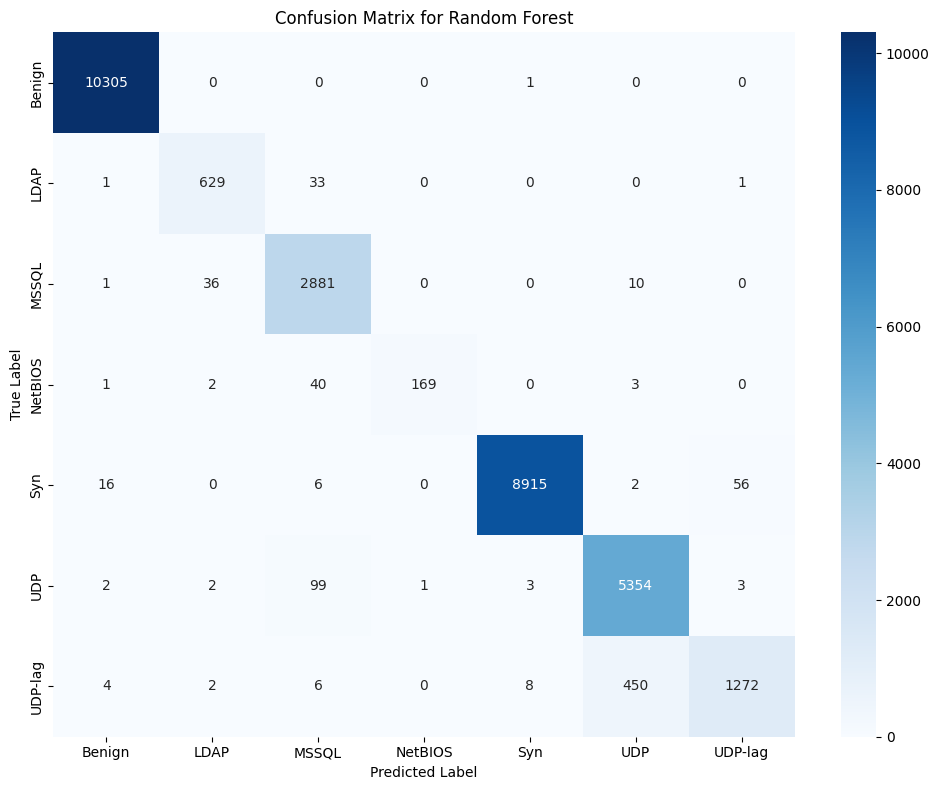

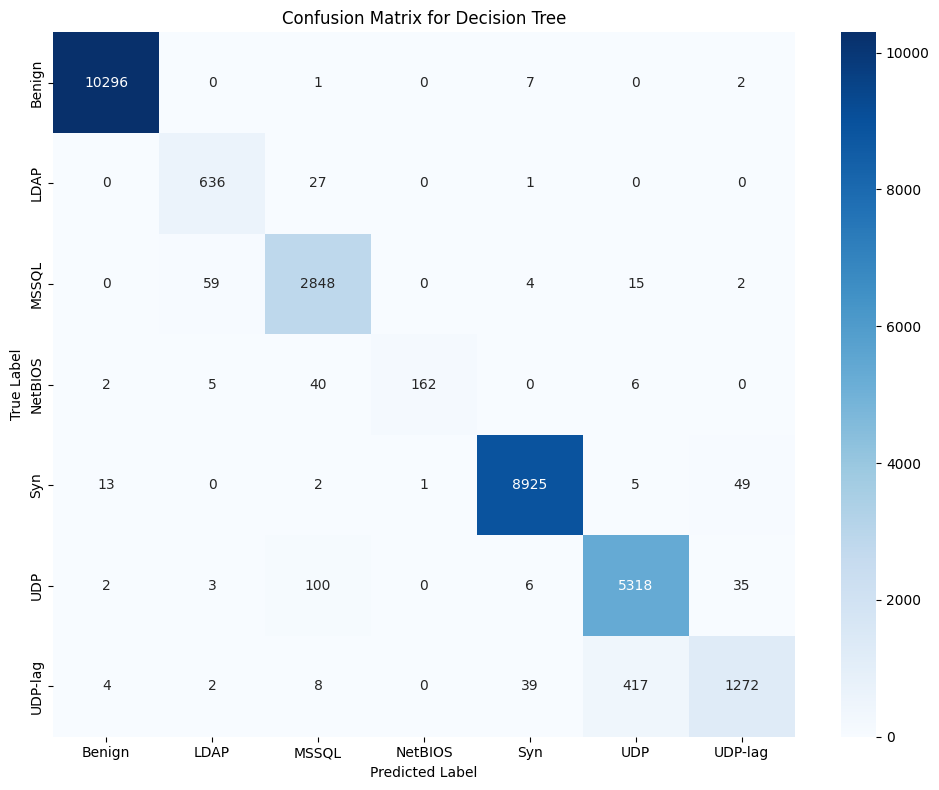

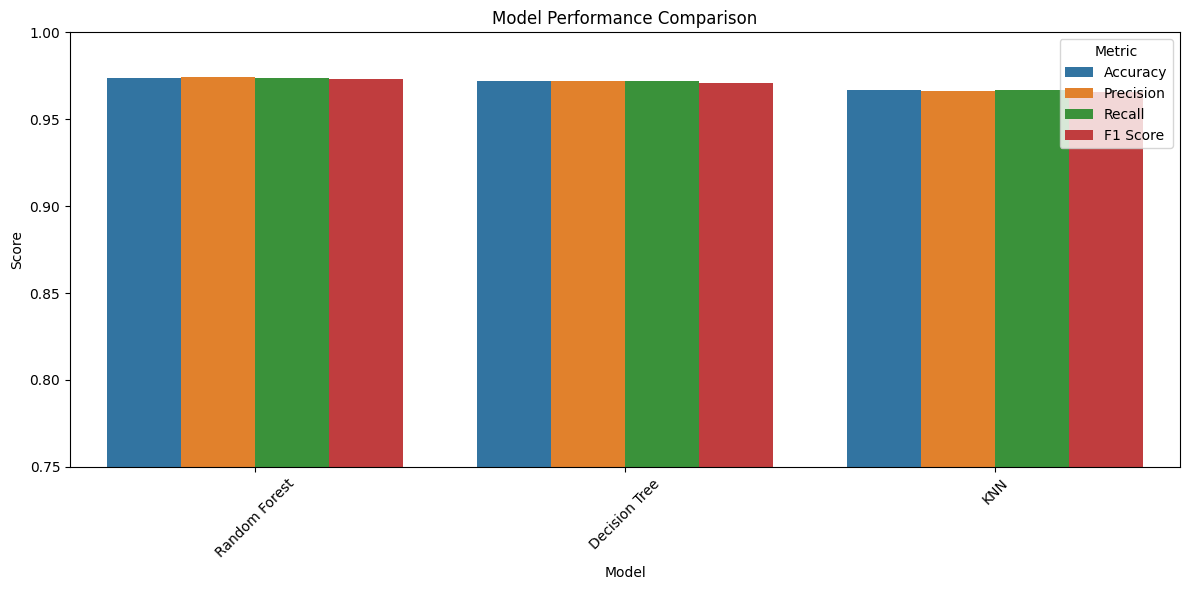


Best performing model based on F1 Score is: Random Forest

Important features:


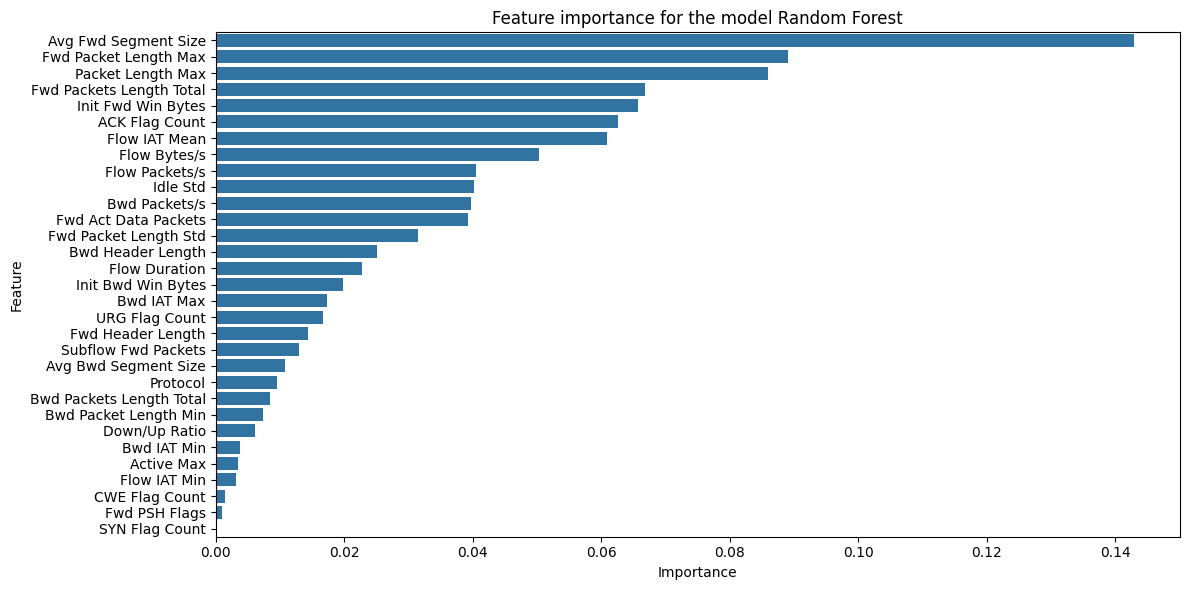

                     Feature  Importance
21      Avg Fwd Segment Size    0.142912
18     Fwd Packet Length Max    0.089076
30         Packet Length Max    0.085962
14  Fwd Packets Length Total    0.066774
17        Init Fwd Win Bytes    0.065694
4             ACK Flag Count    0.062690
15             Flow IAT Mean    0.060970
10              Flow Bytes/s    0.050377
22            Flow Packets/s    0.040450
2                   Idle Std    0.040145
6              Bwd Packets/s    0.039781
28      Fwd Act Data Packets    0.039225
9      Fwd Packet Length Std    0.031555
8          Bwd Header Length    0.025188
20             Flow Duration    0.022832
3         Init Bwd Win Bytes    0.019815
12               Bwd IAT Max    0.017275
11            URG Flag Count    0.016764
1          Fwd Header Length    0.014354
16       Subflow Fwd Packets    0.013016
7       Avg Bwd Segment Size    0.010874
26                  Protocol    0.009561
5   Bwd Packets Length Total    0.008428
19     Bwd Packe

In [22]:
# Confusion matrices for the top 2 models
for name in results_df['Model'][:2]:
    cm, class_names = confusion_matrices[name]
    plot_confusion_matrix(cm, name, class_names)

# Bar chart
plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
df_plot = results_df[['Model'] + metrics].melt(id_vars='Model', value_vars=metrics, var_name='Metric', value_name='Score')
sns.barplot(x='Model', y='Score', hue='Metric', data=df_plot)
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.ylim(0.75, 1.0) # use this to change size of graph
plt.tight_layout()
plt.show()

# Save the best model
best_model_name = results_df.loc[0, 'Model']
best_model = models[best_model_name]
print(f"\nBest performing model based on F1 Score is: {best_model_name}")

# Feature importance for radom forrest
if best_model_name in ["Random Forest"]:
    print("\nImportant features:")
    feature_importance = best_model.feature_importances_

    # Create a DataFrame for feature importance
    importance_df = pd.DataFrame({
        'Feature': X_cleaned.columns,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False).head(34)

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'Feature importance for the model {best_model_name}')
    plt.tight_layout()
    plt.show()

    print(importance_df)

# Ensamble method using voting classifier

In [23]:
# Import ensemble classes for classification
from sklearn.ensemble import VotingClassifier


voting_estimators = [

    ('decisiontree', DecisionTreeClassifier(
        max_depth=15, # 15
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=1)),

    ('randomforrest', RandomForestClassifier(n_estimators=100 , # 100
                                  max_depth=15, # 15
                                  min_samples_split= 5, # 5
                                   min_samples_leaf=2,
                                  random_state=1, # 42
                                  n_jobs=-1)),

    ('knearest', KNeighborsClassifier(n_neighbors=5, # 5
                                 weights='distance',
                                 n_jobs=-1))

]

# VotingClassifier with soft voting ( with averaging the predicted probabilities)
voting_clf = VotingClassifier(
    estimators=voting_estimators,
    voting='hard', # chosen for better results
    n_jobs=-1)

# Train the Voting Classifier
start_time = time.time()
voting_clf.fit(X_train_scaled, y_train)
voting_training_time = time.time() -start_time

# Predict on the test datset
voting_pred = voting_clf.predict(X_test_scaled)

# Calculate performance metrics
voting_accuracy = accuracy_score(y_test, voting_pred )
voting_precision = precision_score(y_test, voting_pred, average='weighted')
voting_recall = recall_score(y_test, voting_pred, average='weighted')
voting_f1 = f1_score(y_test, voting_pred, average='weighted')

# If probabilities are available, calculate ROC AUC
if hasattr(voting_clf, "predict_proba"):
    voting_pred_proba = voting_clf.predict_proba(X_test_scaled)

    try:
        voting_roc_auc = roc_auc_score(y_test, voting_pred_proba, multi_class='ovr')
    except Exception as e:
        voting_roc_auc = np.nan
else:
    voting_roc_auc = np.nan

# Print results
print("Voting Classifier Results:")
print(f"Training Time: {voting_training_time:.2f} seconds")
print(f"Accuracy: {voting_accuracy:.4f}")
print(f"Precision: {voting_precision:.4f}")
print(f"Recall: {voting_recall:.4f}")
print(f"F1 Score: {voting_f1:.4f}")
print(f"Cross-Validation Score (F1): {cv_mean:.4f} (std: {cv_scores.std():.4f})")


Voting Classifier Results:
Training Time: 19.48 seconds
Accuracy: 0.9732
Precision: 0.9737
Recall: 0.9732
F1 Score: 0.9722
Cross-Validation Score (F1): 0.9662 (std: 0.0005)


## Visual comparison

In [24]:
# code to display comparison